In [314]:
import torch
import torch.utils.data as utils
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, sys
import math
import warnings
import itertools
import numbers
import matplotlib.pyplot as plt


from itertools import groupby
from statistics import median,mean,stdev
from scipy import stats as s

### Data Preparation

#### 2- Physioet Challenge dataset

In [315]:
## https://github.com/alistairewj/challenge2012

## Data already processed

In [316]:
root_path = os.getcwd()
dset_path = os.path.join(root_path, "PhysionetChallenge2012", "set-a")
output_dir = os.path.join(root_path, "PhysionetChallenge2012", "processed_Data")
os.makedirs(output_dir, exist_ok = True)

In [317]:
attr_list = [ "RecordID", "Age", "Gender", "Height", "ICUType", "Weight",
                "Albumin", "ALP", "ALT", "AST", "Bilirubin", "BUN", "Cholesterol",
                "Creatinine", "DiasABP", "FiO2", "GCS", "Glucose", "HCO3", "HCT",
                "HR", "K", "Lactate", "Mg", "MAP", "MechVent", "Na", "NIDiasABP",
                "NIMAP", "NISysABP", "PaCO2", "PaO2", "pH", "Platelets", 
                "RespRate", "SaO2", "SysABP", "Temp", "TroponinI", "TroponinT",
                "Urine", "WBC"]

In [318]:
input_feats = {
    "ALP" : 0,             # o
    "ALT" : 1,             # o
    "AST" : 2,             # o
    "Albumin" : 3,         # o
    "BUN" : 4,             # o
    "Bilirubin" : 5,       # o
    "Cholesterol" : 6,     # o
    "Creatinine" : 7,      # o
    "DiasABP" : 8,         # o
    "FiO2" : 9,            # o
    "GCS" : 10,            # o
    "Glucose" : 11,        # o
    "HCO3" : 12,           # o
    "HCT" : 13,            # o
    "HR" : 14,             # o
    "K" : 15,              # o
    "Lactate" : 16,        # o
    "MAP" : 17,            # o
    "Mg" : 18,             # o
    "Na" : 19,             # o
    "PaCO2" : 20,          # o
    "PaO2" : 21,           # o
    "Platelets" : 22,      # o
    "RespRate" : 23,       # o
    "SaO2" : 24,           # o
    "SysABP" : 25,         # o
    "Temp" : 26,           # o
    "Tropl" : 27,          # o
    "TroponinI" : 27,      # temp: regarded same as Tropl
    "TropT" : 28,          # o
    "TroponinT" : 28,      # temp: regarded same as TropT
    "Urine" : 29,          # o
    "WBC" : 30,            # o
    "Weight" : 31,         # o
    "pH" : 32,             # o
    "NIDiasABP" : 33,      # unused variable
    "NIMAP" : 34,          # unused variable
    "NISysABP" : 35,       # unused variable
    "MechVent" : 36,       # unused variable
    "RecordID" : 37,       # unused variable
    "Age" : 38,            # unused variable
    "Gender" :39,          # unused variable
    "ICUType" : 40,        # unused variable
    "Height": 41           # unused variable
}

In [319]:
# functions to process the time in the data
def time_parser(time):
    return pd.to_timedelta(time + ':00')

def time_delta_to_day_figure(timedelta):
    return timedelta.days + (timedelta.seconds/(24*60*60))

In [320]:
# group the data by time
def df_to_inputs(df, inputdict, inputs):
    grouped_data = df.groupby('Time')
            
    for row_index, value in df.iterrows():
        agg_no = inputdict[value.Parameter]
        inputs[agg_no].append(value.Value)    
        
    return inputs

In [321]:
def prepare_raw_data(dset_path, input_feats):
    inputs = []

    for i in range(len(input_feats)-2):
        t = []
        inputs.append(t)

    # Read all the files in the dataset folder
    for filename in os.listdir(dset_path):
        path_file = os.path.join(dset_path, filename)
        df = pd.read_csv(path_file, header=0, parse_dates=['Time'], date_parser=time_parser)

        inputs = df_to_inputs(df=df, inputdict=input_feats, inputs=inputs)
    
    return inputs

In [322]:
inputs = prepare_raw_data(dset_path, input_feats)

In [325]:
len(inputs)

42

In [365]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "inputs")
np.save(input_path, inputs)

In [313]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "inputs")

loaded_inputs = np.load(input_path+".npy", allow_pickle=True)

In [366]:
# make input items list
input_columns = list(input_feats.keys())

input_columns.remove("TroponinI")
input_columns.remove("TroponinT")

print("\t\t Features used: ", input_columns)
print("\t\t Number of features: ", len(input_columns))

		 Features used:  ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'MAP', 'Mg', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'Tropl', 'TropT', 'Urine', 'WBC', 'Weight', 'pH', 'NIDiasABP', 'NIMAP', 'NISysABP', 'MechVent', 'RecordID', 'Age', 'Gender', 'ICUType', 'Height']
		 Number of features:  42


In [367]:
def visualize_feature(inputs, feat_index, feature_name, verbose=True):
    input_arr = np.asarray(inputs[feat_index])
    des = []

    des.append(input_arr.size)
    des.append(np.amin(input_arr))
    des.append(np.amax(input_arr))
    des.append(np.mean(input_arr))
    des.append(np.median(input_arr))
    des.append(np.std(input_arr))
    des.append(np.var(input_arr))
    
    if verbose:
        print("\t\t --------------- Feature: {}, Index: {} ---------------".format(feature_name, feat_index))
        print('\t\t Count: {}, Min: {}, Max: {}'.format(des[0], des[1], des[2]))
        print('\t\t Mean: {}, Median: {}, STD: {}, Var: {}'.format(des[3], des[4], des[5], des[6]))
    
    return input_arr, des        

In [368]:
len(feats_cleaned)

41

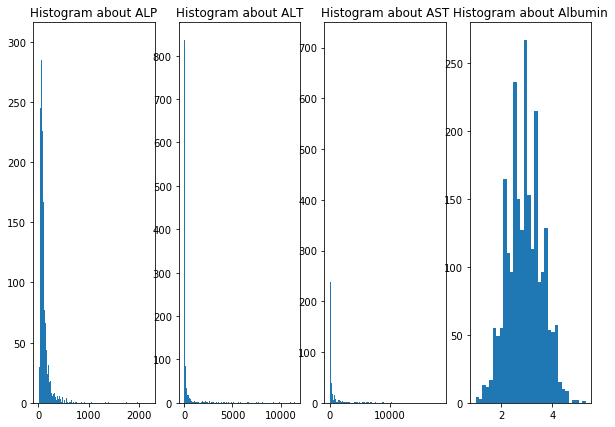

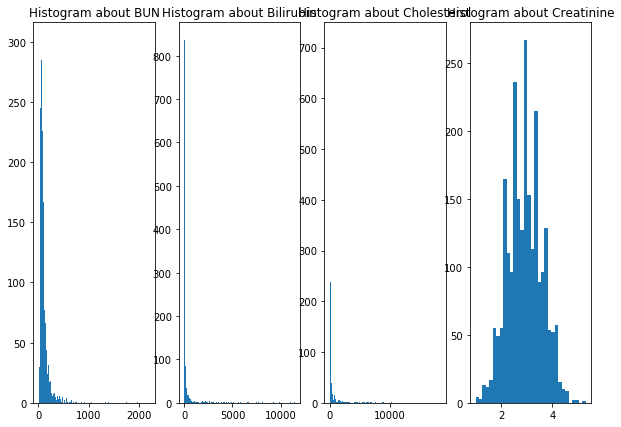

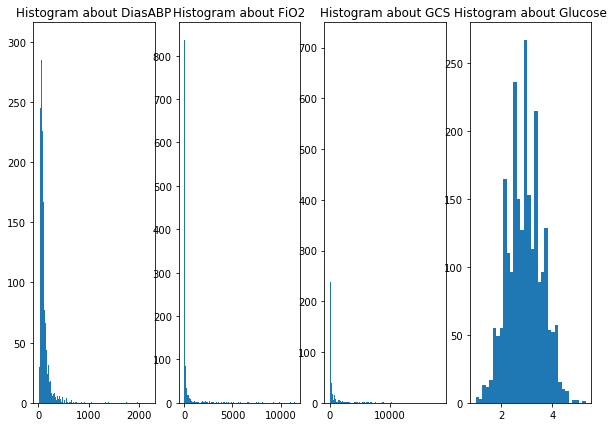

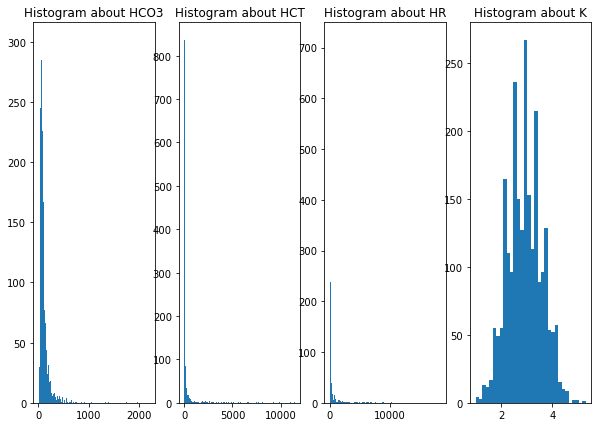

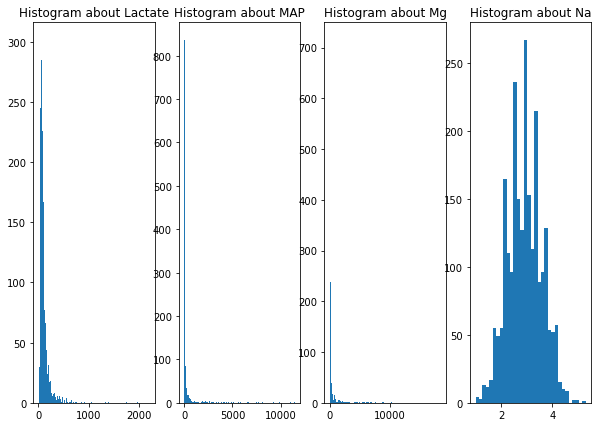

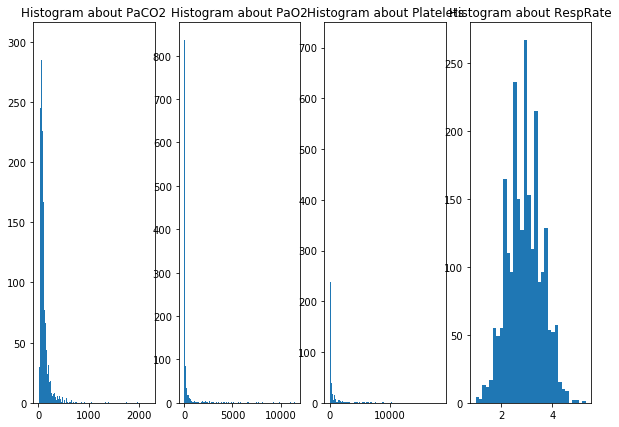

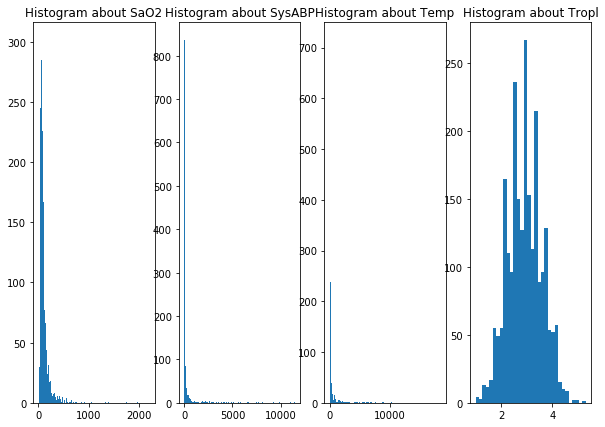

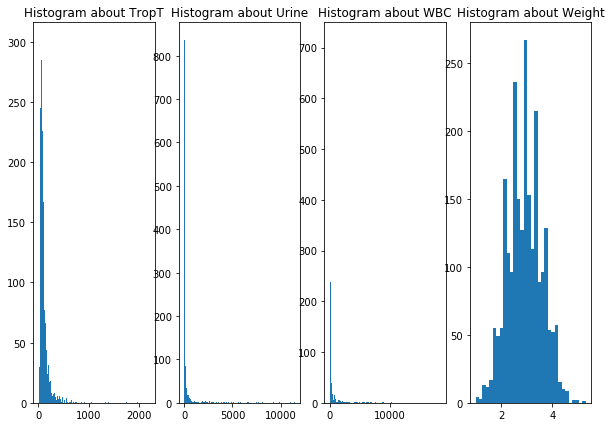

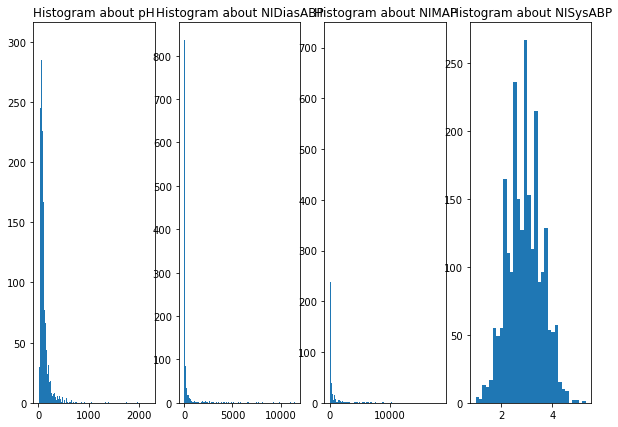

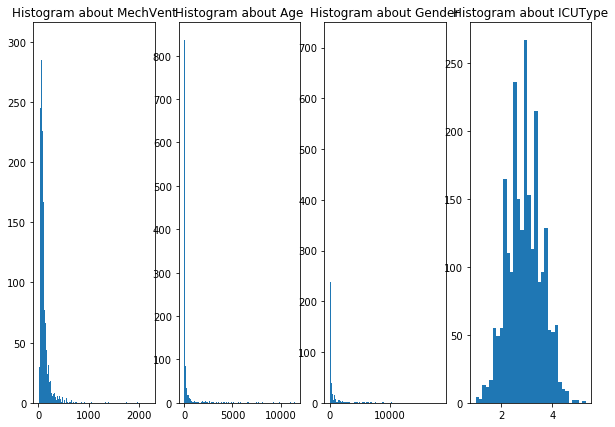

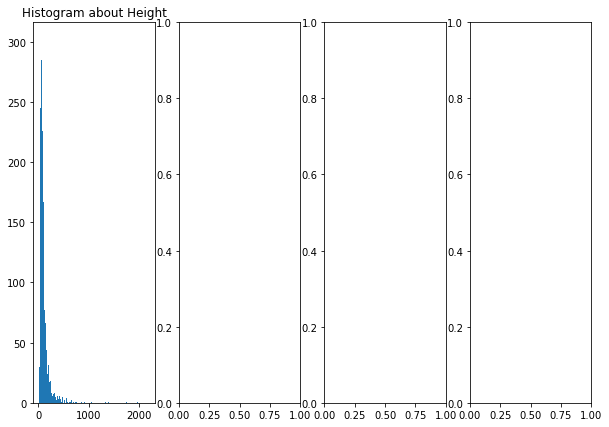

In [159]:
import copy

feats_cleaned = copy.copy(input_columns)
feats_cleaned.remove("RecordID")

for i in range(0, len(feats_cleaned), 4):
    j = i+4
    fig, ax = plt.subplots(1, 4, figsize=(10, 7))
    for ind, feat in enumerate(feats_cleaned[i:j]):
        arr, info = visualize_feature(inputs, ind, feat, verbose=False)
        
        hist = np.hstack(arr)
        ax[ind].hist(hist, bins='auto')
        ax[ind].set_title("Histogram about {}".format(feat))

    plt.show()

In [369]:
def create_DF(df, inputdict, size, id_posistion, split):
    grouped_data = df.groupby('Time')
    
    # Generate input vectors
    x = np.zeros((len(inputdict)-2, grouped_data.ngroups))
    masking = np.zeros((len(inputdict)-2, grouped_data.ngroups))
    delta = np.zeros((split, size))
    timetable = np.zeros(grouped_data.ngroups)
    ID = 0
    
    all_x = np.zeros((split,1))
    s_dataset = np.zeros((3, split, size))
   
    if grouped_data.ngroups > size:
        # Fill the x and masking vectors
        pre_time = pd.to_timedelta(0)
        t = 0
        for row_index, value in df.iterrows():
            agg_no = inputdict[value.Parameter]

            # Same timeline check.        
            if pre_time != value.Time:
                pre_time = value.Time
                t += 1
                timetable[t] = timedelta_to_day_figure(value.Time)

            x[agg_no, t] = value.Value    
            masking[agg_no, t] = 1
        
        # Generate index that has most parameters and first/last one.
        ran_index = grouped_data.count()
        ran_index = ran_index.reset_index()
        ran_index = ran_index.sort_values('Value', ascending=False)
        ran_index = ran_index[:size]
        ran_index = ran_index.sort_index()
        ran_index = np.asarray(ran_index.index.values)
        ran_index[0] = 0
        ran_index[size-1] = grouped_data.ngroups-1
        
        # Take ID for outcome comparing
        ID = x[id_posistion, 0]
        
        # Remove unnesserly parts(rows)
        x = x[:split, :]
        masking = masking[:split, :]
        
        # Column(time) sampling
        x_sample = np.zeros((split, size))
        m_sample = np.zeros((split, size))
        time_sample = np.zeros(size)

        t_x_sample = x_sample.T
        t_marsking = m_sample.T
        
        t_x = x.T
        t_m = masking.T

        it = np.nditer(ran_index, flags=['f_index'])
        while not it.finished:
            t_x_sample[it.index] = t_x[it[0]]
            t_marsking[it.index] = t_m[it[0]]
            time_sample[it.index] = timetable[it[0]]
            it.iternext()
        
        x = x_sample
        masking = m_sample
        timetable = time_sample

        # Fill the delta vectors
        for index, value in np.ndenumerate(masking):
            if index[1] == 0:
                delta[index[0], index[1]] = 0
            elif masking[index[0], index[1]-1] == 0:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1] + delta[index[0], index[1]-1]
            else:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1]
    
    else:    
        # Fill the x and masking vectors
        pre_time = pd.to_timedelta(0)
        t = 0
        for row_index, value in df.iterrows():
            agg_no = inputdict[value.Parameter]

            # Same timeline check.        
            if pre_time != value.Time:
                pre_time = value.Time
                t += 1
                timetable[t] = timedelta_to_day_figure(value.Time)

            x[agg_no, t] = value.Value    
            masking[agg_no, t] = 1
        
        # Take id for outcome comparing
        ID = x[id_posistion, 0]
        
        # Remove unnesserly parts(rows)
        x = x[:split, :]
        masking = masking[:split, :]
        
        x = np.pad(x, ((0,0), (size-grouped_data.ngroups, 0)), 'constant')
        masking = np.pad(masking, ((0,0), (size-grouped_data.ngroups, 0)), 'constant')
        timetable = np.pad(timetable, (size-grouped_data.ngroups, 0), 'constant')

        # Fill the delta vectors
        for index, value in np.ndenumerate(masking):
            if index[1] == 0:
                delta[index[0], index[1]] = 0
            elif masking[index[0], index[1]-1] == 0:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1] + delta[index[0], index[1]-1]
            else:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1]
    

    all_x = np.concatenate((all_x, x), axis=1)
    all_x = all_x[:,1:]
    
    s_dataset[0] = x
    s_dataset[1] = masking
    s_dataset[2] = delta
    
    return s_dataset, all_x, ID

In [166]:
size = 49 # steps ~ from the paper
id_position = 37
input_length = 33 # input variables ~ from the paper
dataset = np.zeros((1,3, input_length, size))

all_x_add = np.zeros((input_length, 1))

for filename in os.listdir(dset_path):
    path_file = os.path.join(dset_path, filename)
    df = pd.read_csv(path_file, header=0, parse_dates=['Time'], date_parser=timeparser)
    s_dataset, all_x, ID = create_DF(df=df, inputdict=input_feats, size=size, id_posistion=id_position, split=input_length)
    
    dataset = np.concatenate((dataset, s_dataset[np.newaxis, :,:,:]))
    all_x_add = np.concatenate((all_x_add, all_x), axis=1)

In [167]:
dataset = dataset[1:, :, :, :]    
all_x_add = all_x_add[:, 1:]

(4000, 3, 33, 49)
(3, 33, 49)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
(33, 196001)
(33, 196000)


In [170]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "dataset")
np.save(input_path, dataset)

In [172]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "all_x_add")
np.save(input_path, all_x_add)

In [184]:
print("\t\t Dataset (N, (X, X_Mask, Delta), Input_length, Variance): {}".format(dataset.shape))
print("\t\t All_X : {}".format(all_x_add.shape))

		 Dataset (N, (X, X_Mask, Delta), Input_length, Variance): (4000, 3, 33, 49)
		 All_X : (33, 196000)


In [370]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "dataset")
dataset = np.load(input_path+".npy", allow_pickle=True)
print("\t\t Dataset shape: ", dataset.shape)

input_path = os.path.join(root_path, "PhysionetChallenge2012", "all_x_add")
all_x_add = np.load(input_path+".npy", allow_pickle=True)
print("\t\t All_x shape: ", all_x_add.shape)

		 Dataset shape:  (4000, 3, 33, 49)
		 All_x shape:  (33, 196000)


In [371]:
train_proportion = 0.8
train_index = int(all_x_add.shape[1] * train_proportion)
X_train = all_x_add[:, :train_index]
print("\t\t X_train: ", X_train.shape)

		 X_train:  (33, 156800)


In [372]:
def get_mean(x):
    x_mean = []
    for i in range(x.shape[0]):
        mean = np.mean(x[i])
        x_mean.append(mean)
    return x_mean

def get_median(x):
    x_median = []
    for i in range(x.shape[0]):
        median = np.median(x[i])
        x_median.append(median)
    return x_median

def get_std(x):
    x_std = []
    for i in range(x.shape[0]):
        std = np.std(x[i])
        x_std.append(std)
    return x_std

def get_var(x):
    x_var = []
    for i in range(x.shape[0]):
        var = np.var(x[i])
        x_var.append(var)
    return x_var

In [188]:
x_mean = get_mean(X_train)
x_std = get_std(X_train)

In [189]:
def dataset_normalize(dataset, mean, std):
    for i in range(dataset.shape[0]):        
        dataset[i][0] = (dataset[i][0] - mean[:, None])
        dataset[i][0] = dataset[i][0]/std[:, None]
        
    return dataset

In [190]:
x_mean = np.asarray(x_mean)
x_std = np.asarray(x_std)

dataset_normalized = dataset_normalize(dataset=dataset, mean=x_mean, std=x_std)

In [197]:
print("\t\t Normalized dataset: ", dataset_normalized.shape)

		 Normalized dataset:  (4000, 3, 33, 49)


In [373]:
def normalize_chk(dataset):
    all_x_add = np.zeros((dataset[0][0].shape[0], 1))
    for i in range(dataset.shape[0]):
        all_x_add = np.concatenate((all_x_add, dataset[i][0]), axis=1)
    
    mean = get_mean(all_x_add)
    median = get_median(all_x_add)
    std = get_std(all_x_add)
    var = get_var(all_x_add)

    return mean, median, std, var

In [194]:
nor_mean, nor_median, nor_std, nor_var = normalize_chk(dataset_normalized)

In [198]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "X_mean_norm")
np.save(input_path, nor_mean)

input_path = os.path.join(root_path, "PhysionetChallenge2012", "X_median_norm")
np.save(input_path, nor_median)

input_path = os.path.join(root_path, "PhysionetChallenge2012", "X_std_norm")
np.save(input_path, nor_std)

input_path = os.path.join(root_path, "PhysionetChallenge2012", "dataset_norm")
np.save(input_path, dataset_normalized)

In [374]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "dataset_norm")
dataset_normalized = np.load(input_path +".npy")

print("\t\t Normalized dataset: ", dataset_normalized.shape)

		 Normalized dataset:  (4000, 3, 33, 49)


In [375]:
def y_labels(df):
    '''
    RecordID  SAPS-I  SOFA  Length_of_stay  Survival  In-hospital_death
    '''
    output = np.zeros((4000, 3))
    
    for row_index, value in df.iterrows():
        los = value[3] # Length_of_stay
        sur = value[4] # Survival
        ihd = value[5] # In-hospital_death

        output[row_index][0] = ihd
        output[row_index][1] = ihd

        # length-of-stay less than 3 yes/no 1/0
        if los < 3:
            output[row_index][2] = 0
        else:
            output[row_index][2] = 1

    return output

# only check In-hospital_death
def ylabel_In_Hospital(df):
    output = df.values
    output = output[:,5:]

    return output

In [376]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "Outcomes-a.txt")
A_outcomes = pd.read_csv(input_path)

y1_outcomes = ylabel_In_Hospital(A_outcomes)
print("\t\t Y labels: ", y1_outcomes.shape)

		 Y labels:  (4000, 1)


In [203]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "y1_out")
np.save(input_path, y1_outcomes)

In [377]:
def ylabel_hotencode(df):
    '''
    RecordID  SAPS-I  SOFA  Length_of_stay  Survival  In-hospital_death
    '''
    output = np.zeros((4000, 2))
    
    for row_index, value in df.iterrows():
        ihd = value[5] # In-hospital_death

        output[row_index][ihd] = 1
    return output

In [378]:
input_path = os.path.join(root_path, "PhysionetChallenge2012", "Outcomes-a.txt")
A_outcomes = pd.read_csv(input_path)

y2_outcomes = ylabel_hotencode(A_outcomes)

--------------------------------------------------------------------------

#### Exploratory Data Analysis